In [1]:
##### Required packages
# opencv-python
# matplotlib
# sklearn
# tensorflow
# keras
# numpy

import os
import cv2
import numpy as np
import re
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Directory containing the data
data_dir = "Data/Mild Dementia"

# Number of components for PCA
n_components = 64

# Lists to store preprocessed features and labels
preprocessed_features = []
labels = []


# Function to denoise and enhance an image
def denoise_and_enhance(image):
    # Convert the image to grayscale
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Gaussian blur for denoising
    denoised_img = cv2.GaussianBlur(gray_img, (3, 3), 0)
    # Apply histogram equalization for enhancing contrast
    enhanced_img = cv2.equalizeHist(denoised_img)
    return enhanced_img


# Function to apply contraharmonic mean filter
def contraharmonic_mean_filter(img, Q):
    num = np.power(img, Q + 1)
    denom = np.power(img, Q)
    kernel = np.full((3, 3), 1.0)
    result = cv2.filter2D(num, -1, kernel) / (cv2.filter2D(denom, -1, kernel) + 1e-6)
    return result


# Function to generate Gabor filters
def get_gabor_filters():
    filters = []
    num_filters = 16
    ksize = 15
    sigma = 3.0
    lambd = 10.0
    gamma = 0.5
    psi = 0
    for theta in np.arange(0, np.pi, np.pi / num_filters):
        # Generate Gabor kernel for each orientation
        kern = cv2.getGaborKernel(
            (ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_64F
        )
        kern /= 1.0 * kern.sum()
        filters.append(kern)
    return filters


# Get Gabor filters
gabor_bank = get_gabor_filters()


# Function to extract Gabor features from an image
def extract_gabor_features(image):
    global gabor_bank
    final_image = np.zeros_like(image)
    depth = -1
    for filter in gabor_bank:
        # Apply each Gabor filter to the image and take element-wise maximum
        filtered_image = cv2.filter2D(image, depth, filter)
        np.maximum(final_image, filtered_image, final_image)
    return final_image


# Function to apply Principal Component Analysis (PCA) for feature reduction
def apply_pca(features):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features


# Regular expressions to extract information from filenames
pattern_id1 = r"(?<=_)\d{4}"  # Extract ID
pattern_id3 = r"\d+(?=\.)"  # Extract slice number

# Iterate through each image file in the directory
filenames = sorted(os.listdir(data_dir))
for filename in filenames:
    id = re.search(pattern_id1, filename).group(0)
    slice = int(re.search(pattern_id3, filename).group(0))

    # Select images with slice numbers between 120 and 139
    if slice >= 120 and slice < 140:
        image_path = os.path.join(data_dir, filename)

        if filename.endswith(".jpg"):
            # Read image
            image = cv2.imread(image_path)
            # Preprocess image (denoise and enhance)
            enhanced_image = denoise_and_enhance(image)
            # Apply contraharmonic mean filter
            contra_enhanced_image = contraharmonic_mean_filter(enhanced_image, 0.5)
            # Extract Gabor features
            gabor_features = extract_gabor_features(contra_enhanced_image)
            # Apply PCA for feature reduction
            compressed_features = apply_pca(gabor_features)
            # Store preprocessed features and labels
            preprocessed_features.append(compressed_features)
            labels.append(id)

In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Print the number of samples (images) and the number of classes (unique labels)
print("No.of Samples :", len(labels))
distinct_labels = set(labels)
num_classes = len(distinct_labels)
print("No.of Classes :", num_classes)

# Convert preprocessed features and labels to numpy arrays
images = np.array(preprocessed_features)
class_labels = np.array(labels)

# Initialize a LabelEncoder to convert class labels to integers
label_encoder = LabelEncoder()
# Fit the LabelEncoder on the unique class labels and transform the labels to integers
label_encoder.fit(np.unique(labels))
labels_encoded = label_encoder.transform(labels)
# Convert integer labels to one-hot encoded categorical labels
labels_categorical = tf.keras.utils.to_categorical(labels_encoded, num_classes)

# Print the shapes of the images and labels
print("Images shape  :", images.shape)
print("Labels shape  :", labels_categorical.shape)

# Define the input shape for the neural network
input_shape = images[0].shape

2024-05-14 17:03:25.148221: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-14 17:03:25.150315: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 17:03:25.206175: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-14 17:03:25.460020: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 17:03:26.567750: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

No.of Samples : 1640
No.of Classes : 21
Images shape  : (1640, 248, 64)
Labels shape  : (1640, 21)


In [3]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
# x_train: training images, x_test: testing images
# y_train: corresponding training labels, y_test: corresponding testing labels
# test_size: the proportion of the dataset to include in the test split
# shuffle: whether to shuffle the data before splitting
# random_state: seed for random number generation, ensures reproducibility
x_train, x_test, y_train, y_test = train_test_split(
    images, labels_categorical, test_size=0.15, shuffle=True, random_state=42
)

In [4]:
from keras import Sequential
from keras import (
    Conv2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
    MaxPooling2D,
)

# Initialize a sequential model
model = Sequential()

# Add a 2D convolutional layer with 32 filters, kernel size (2, 2), and input shape
model.add(
    Conv2D(
        32,
        kernel_size=(2, 2),
        input_shape=(input_shape[0], input_shape[1], 1),
        padding="Same",
    )
)
# Add another 2D convolutional layer with 32 filters and kernel size (2, 2)
model.add(Conv2D(32, kernel_size=(2, 2), activation="relu", padding="Same"))

# Add batch normalization layer to normalize the activations of the previous layer
model.add(BatchNormalization())
# Add max pooling layer with pool size (2, 2)
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropout layer with dropout rate of 0.25
model.add(Dropout(0.25))

# Add another 2D convolutional layer with 64 filters and kernel size (2, 2)
model.add(Conv2D(64, kernel_size=(2, 2), activation="relu", padding="Same"))
# Add another 2D convolutional layer with 64 filters and kernel size (2, 2)
model.add(Conv2D(64, kernel_size=(2, 2), activation="relu", padding="Same"))

# Add batch normalization layer
model.add(BatchNormalization())
# Add max pooling layer with pool size (2, 2) and strides (2, 2)
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
# Add dropout layer with dropout rate of 0.25
model.add(Dropout(0.25))

# Flatten the previous layer
model.add(Flatten())

# Add a fully connected dense layer with 512 neurons and ReLU activation function
model.add(Dense(512, activation="relu"))
# Add dropout layer with dropout rate of 0.5
model.add(Dropout(0.5))
# Add output layer with softmax activation function
model.add(Dense(num_classes, activation="softmax"))

# Compile the model with categorical crossentropy loss and Adamax optimizer
model.compile(loss="categorical_crossentropy", optimizer="Adamax", metrics=["accuracy"])

# Print model summary
print(model.summary())

/home/surya/IIITDM/Sem_6/ITB/mrimetric/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 248, 64, 32)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 248, 64, 32)    │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 248, 64, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 124, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 124, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 124, 32, 64)    │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 124, 32, 64)    │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 124, 32, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 63488)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    32,506,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 21)             │        10,773 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,546,517 (124.16 MB)

 Trainable params: 32,546,325 (124.15 MB)

 Non-trainable params: 192 (768.00 B)

None


In [5]:
# Train the model on the training data
# x_train: input training data
# y_train: target training data (labels)
# epochs: number of epochs to train the model
# batch_size: number of samples per gradient update
# verbose: verbosity mode (0: silent, 1: progress bar, 2: one line per epoch)
# validation_data: data on which to evaluate the loss and any model metrics at the end of each epoch
history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=10,
    verbose=1,
    validation_data=(x_test, y_test),
)

Epoch 1/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 107s 749ms/step - accuracy: 0.0900 - loss: 19.7180 - val_accuracy: 0.1341 - val_loss: 2.9864
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 105s 748ms/step - accuracy: 0.1548 - loss: 2.5767 - val_accuracy: 0.2561 - val_loss: 2.5034
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 105s 747ms/step - accuracy: 0.2443 - loss: 2.2368 - val_accuracy: 0.5650 - val_loss: 2.0379
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 104s 741ms/step - accuracy: 0.3624 - loss: 1.8928 - val_accuracy: 0.6951 - val_loss: 1.4729
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 104s 747ms/step - accuracy: 0.5308 - loss: 1.4009 - val_accuracy: 0.7927 - val_loss: 1.1743
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 104s 744ms/step - accuracy: 0.6502 - loss: 1.0627 - val_accuracy: 0.8659 - val_loss: 0.6190
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 104s 743ms/step - accuracy: 0.7350 - loss: 0.7234 - val_accuracy: 0.9593 - val_loss: 0.3986
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 92s 654ms/step - accuracy: 0.8279 -

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - accuracy: 0.9924 - loss: 0.0484
Test Accuracy: 0.9878048896789551


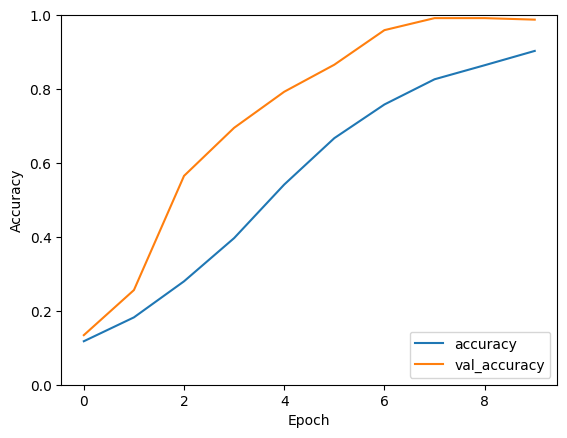

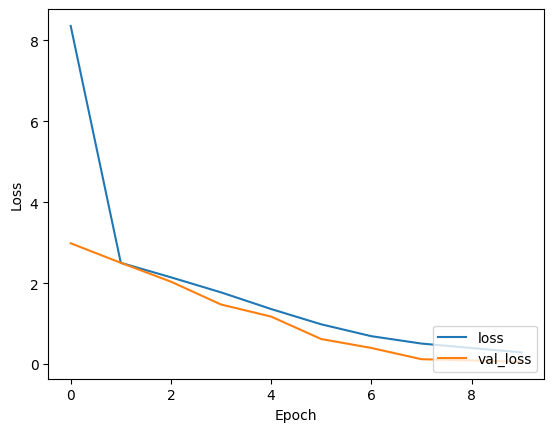

In [6]:
# Evaluate the model on the test data and get the loss and accuracy
loss, accuracy = model.evaluate(x_test, y_test)
print("Test Accuracy:", accuracy)

# Plot the training and validation accuracy over epochs
plt.plot(history.history["accuracy"], label="accuracy")  # Training accuracy
plt.plot(history.history["val_accuracy"], label="val_accuracy")  # Validation accuracy
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0, 1])
plt.legend(loc="lower right")
plt.show()

# Plot the training and validation loss over epochs
plt.plot(history.history["loss"], label="loss")  # Training loss
plt.plot(history.history["val_loss"], label="val_loss")  # Validation loss
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(loc="lower right")
plt.show()